# Development of PulseAI - Emotion Recognition System

Facial expressions convey a significant amount of information about human emotions and intentions. In the age of artificial intelligence, the ability to automatically recognize and interpret these expressions can play a pivotal role in various applications, from enhancing human-computer interactions to offering insights into mental health. As a step towards harnessing this potential, we have developed an advanced image recognition system using the fast.ai library, leveraging the widely-used FER-2013 dataset.

### FER-2013 Dataset Overview

The Facial Expression Recognition 2013 (FER-2013) dataset comprises grayscale images, each of size 48x48 pixels. These images are categorized into seven distinct emotion labels: angry, disgust, fear, happy, sad, surprise, and neutral. With over 35,000 images, the dataset provides a comprehensive collection of facial expressions that is representative of various demographics, making it an excellent choice for training and testing facial recognition models.

### Empowering the System with fast.ai

fast.ai is a deep learning library designed to make the process of training complex models as intuitive and streamlined as possible. With its high-level APIs and underlying robust mechanisms, it significantly reduces the learning curve for beginners, while offering granular control for experienced users. In this project, the library facilitated rapid prototyping, allowing us to experiment with a variety of architectures and techniques seamlessly.

Model Selection and Performance

Our development journey included testing multiple neural network architectures. Starting with simpler convolutional networks, we gradually moved to more intricate models, tweaking hyperparameters, and utilizing fast.ai's built-in functionalities like learning rate finders. After rigorous training and validation, we selected the best-performing model, ensuring a balance between accuracy and computational efficiency.

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
from fastai.vision.all import *

# Fix the seed for reproducibility
np.random.seed(42) # numpy
torch.manual_seed(42) # pytorch
random.seed(42) # python

/Users/nmirabets/Documents/data-science/repos/emotion-recognition/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
class Dataset():
    
    batch_size = 64
    pixel_size = 48

    def __init__(self, path):
        self.path = path

    def get_data_loader(self):
        self.dls = ImageDataLoaders.from_folder(self.path, 
                                                         train='train', 
                                                         valid='test', 
                                                         bs=self.batch_size, 
                                                         item_tfms=Resize(self.pixel_size))
        return self.dls
    
    def get_balanced_data_loader(self):
        train_data = datasets.ImageFolder(self.path+"train")

        # Count the number of images per class in the training dataset
        class_counts = dict(Counter(train_data.targets))

        # Calculate class weights for WeightedRandomSampler
        class_weights = [1 / class_counts[i] for i in class_counts]

        print("class_weights: ", class_weights)

        # Create a sampler using the weights
        sampler = WeightedRandomSampler(weights=class_weights, 
                                        num_samples=len(train_data),
                                        replacement=True)
        
        self.dls = ImageDataLoaders.from_folder(self.path, 
                                                         train='train', 
                                                         valid='test', 
                                                         bs=self.batch_size, 
                                                         item_tfms=Resize(self.pixel_size))

        return self.dls

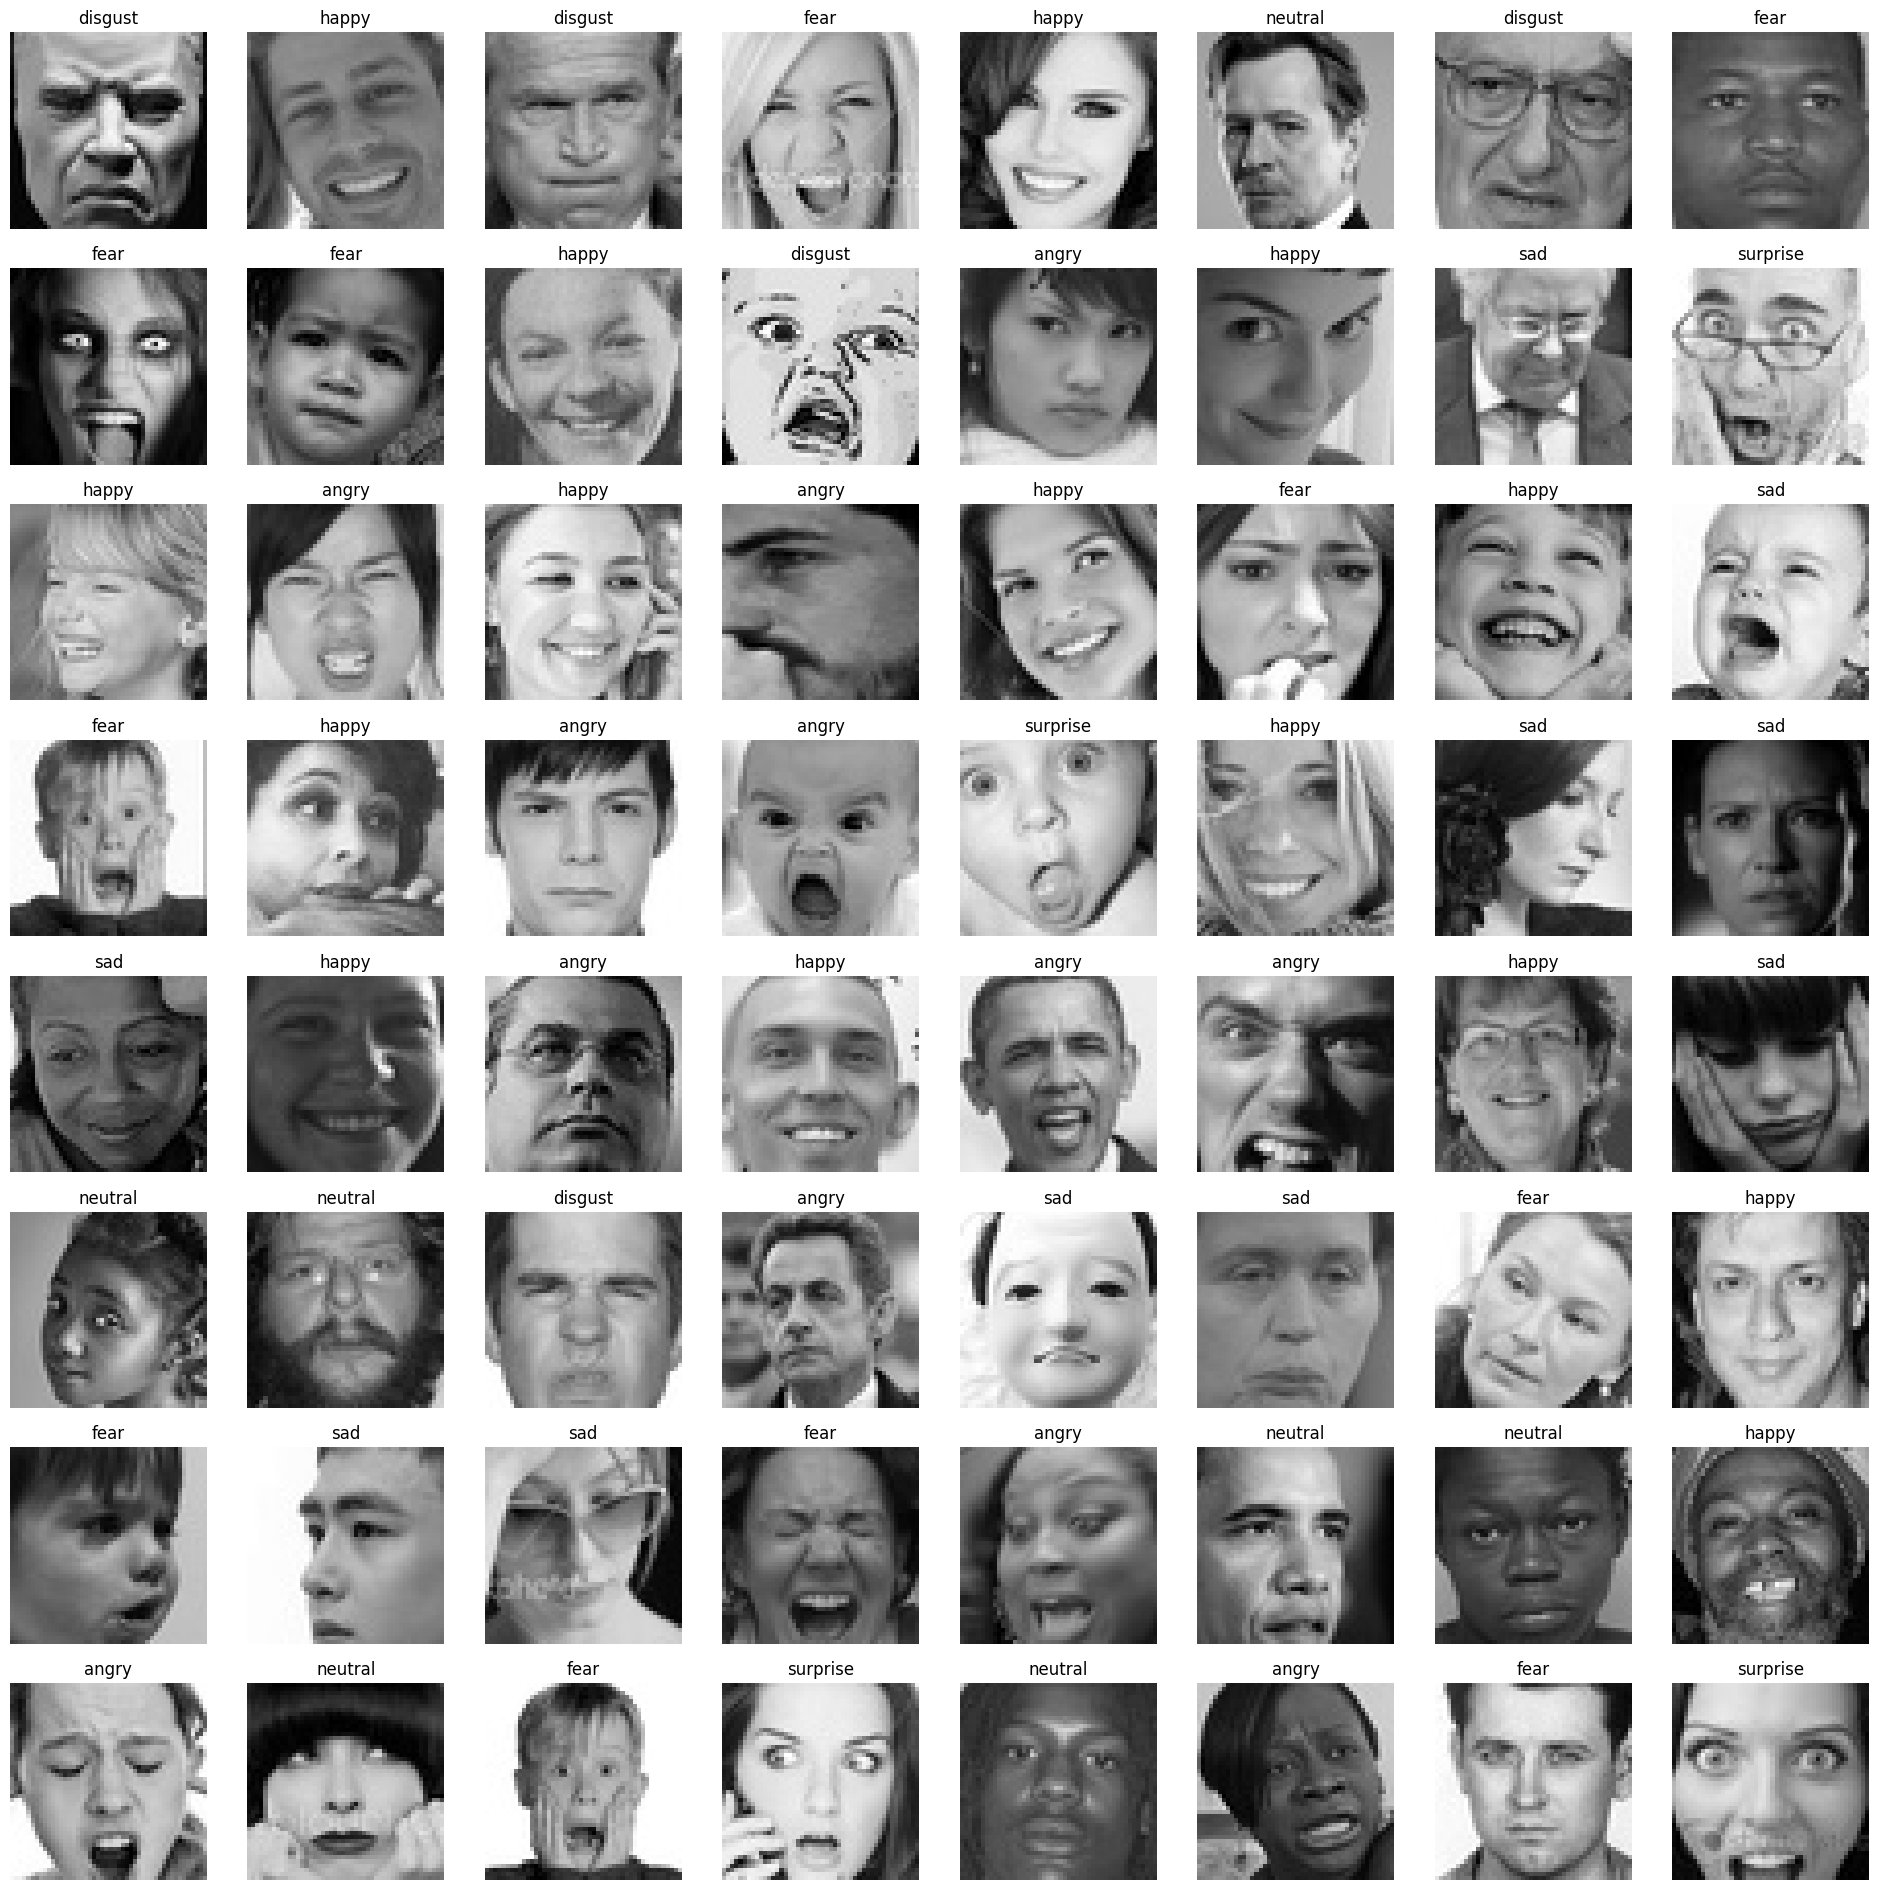

In [4]:
# Define dataset path
path = "../data/fer-2013/"
#path = "../data/balanced_fer-2013/"

# Create dataloader
dls = Dataset(path).get_data_loader()

# Show batch
dls.show_batch(max_n=64, ncols=8)

## Model selection & tuning

In [5]:
# Function to save the metrics from a fastai learner to a csv file
def save_learner_metrics(learner, path):

    # Get the metric names
    cols = learner.recorder.metric_names[1:-1]
    
    # Get the values from the recorder to df
    df = pd.DataFrame(learner.recorder.values, columns=cols)

    # Create a new column with the epoch number
    df['epoch'] = df.index + 1

    # Move epoch column to the front
    cols = list(df.columns[-1:]) + list(df.columns[:-1])
    df = df[cols]

    # Save to csv
    df.to_csv(path, index=False)

/Users/nmirabets/Documents/data-science/repos/emotion-recognition/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nmirabets/Documents/data-science/repos/emotion-recognition/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/Users/nmirabets/Documents/data-science/repos/emotion-recognition/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nmirabets/Documents/data-science/repos/emotion-recognition/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


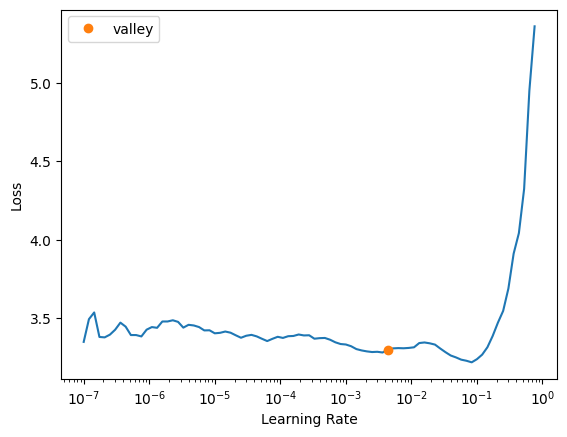

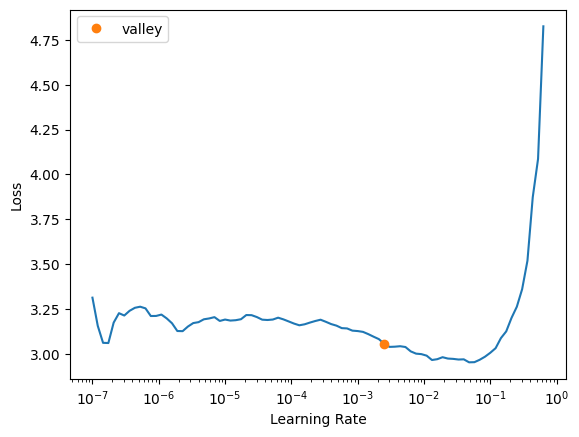

In [6]:
#Define base path
base_path = '/Users/nmirabets/Documents/data-science/repos/emotion-recognition'

# Define train_id
train_id = 'NB_2'

# Define models to test
models_to_test = [resnet50, vgg16_bn]

# Define epochs
epochs = 3

# Initialize list of learners
learners = []

for model in models_to_test: # Loop through the models

    # Create learner
    learn = vision_learner(dls, model, metrics=[accuracy], 
                            cbs=Recorder(valid_metrics=True, train_metrics=True, add_time=True))

    # Find optimal learning rate
    suggested_lr = learn.lr_find().valley

    # Train model
    learn.fine_tune(epochs, suggested_lr)

    # Define learner name
    learner_name = f'{train_id}_{model.__name__ }_epochs_{epochs}_lr_{round(suggested_lr,4)}'

    # Append learner to list
    learners.append({'name': learner_name, 'learner': learn})

    # Save metrics
    save_learner_metrics(learn, f'{base_path}/learner_metrics/{learner_name}.csv')

    # Save model
    learn.export(f'{base_path}/models/{learner_name}.pth')

## Model Evaluation

In [7]:
def plot_learner_metrics(learner):

    # Get the metric names
    cols = learner.recorder.metric_names[1:-1]
    
    # Get the values from the recorder to df
    df = pd.DataFrame(learner.recorder.values, columns=cols)

    # Create a new column with the epoch number
    df['epoch'] = df.index + 1

    # Move epoch column to the front
    cols = list(df.columns[-1:]) + list(df.columns[:-1])

    # Reorder the columns
    df = df[cols]

    # Display df
    display(df)

    # Get model name
    model_name = str(learner.model).split("(")[0]

    # Plot the loss vs. epoch chart
    plt.figure()
    plt.plot(range(1, epochs + 1), df['train_loss'], label='Training Loss')
    plt.plot(range(1, epochs + 1), df['valid_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Model: {model_name}')
    plt.legend()
    plt.show()

### Plot loss curves

Learner:  NB_2_resnet50_epochs_3_lr_0.0044


,epoch,train_loss,train_accuracy,valid_loss,valid_accuracy
0,1,1.311067,0.462123,1.222660,0.537336
1,2,1.051765,0.592843,1.055959,0.608805
2,3,0.580447,0.786307,1.102175,0.625662


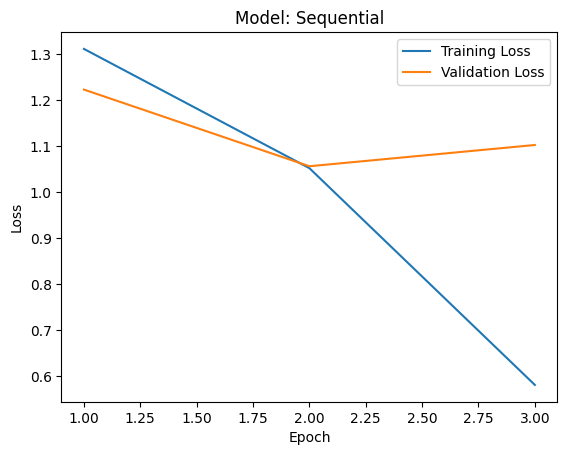

Learner:  NB_2_vgg16_bn_epochs_3_lr_0.0025


,epoch,train_loss,train_accuracy,valid_loss,valid_accuracy
0,1,1.245989,0.470250,1.158259,0.557398
1,2,1.002597,0.621791,1.028422,0.627194
2,3,0.517859,0.809570,1.106769,0.639315


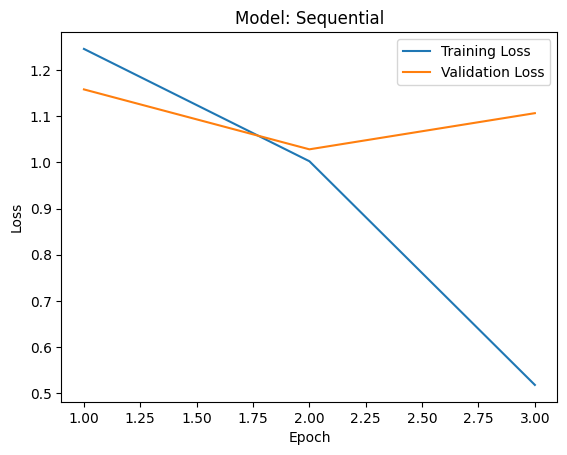

In [8]:
for learner in learners:
    print('Learner: ', learner['name'])
    plot_learner_metrics(learner['learner'])

### Model Selected -> TBD

## Absolute Confusion Matrix

NB_2_resnet50_epochs_3_lr_0.0044


NB_2_vgg16_bn_epochs_3_lr_0.0025


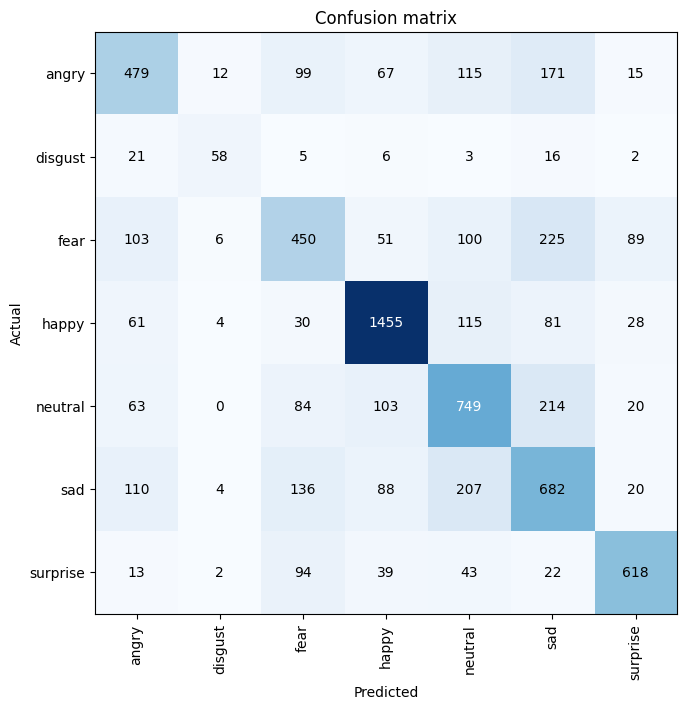

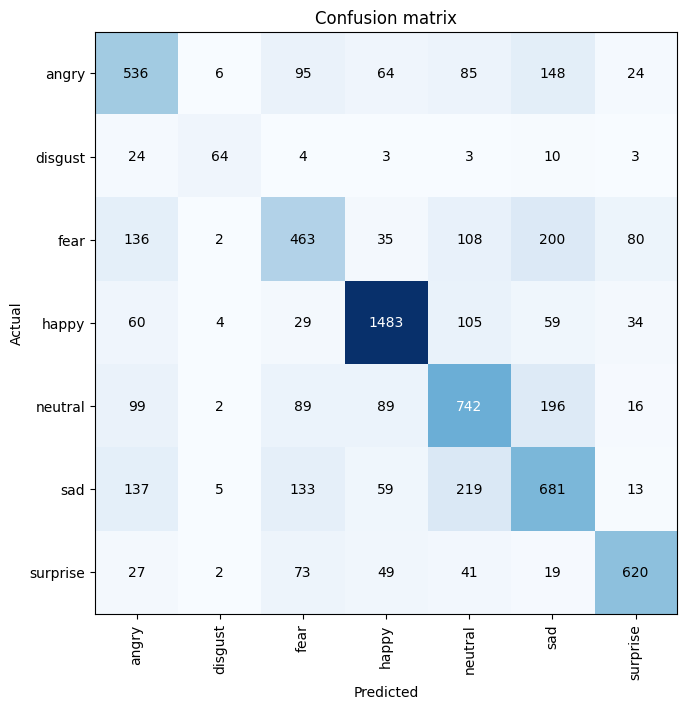

In [9]:
for learner in learners:
    print(learner['name'])
    interp = ClassificationInterpretation.from_learner(learner['learner'])
    losses,idxs = interp.top_losses()
    interp.plot_confusion_matrix(figsize=(7, 7), dpi=100)

## Percentual Confusion Matrix

In [10]:
# Custom function to plot confusion matrix with percentages
def plot_confusion_matrix_percent(cm, classes, figsize=(7, 7), dpi=100):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar(cax)
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cm[i, j]:.2f}%", va='center', ha='center', color='white' if cm[i, j] > 50 else 'black')
    
    plt.xticks(np.arange(len(classes)), classes, rotation=90)
    plt.yticks(np.arange(len(classes)), classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

NB_2_resnet50_epochs_3_lr_0.0044


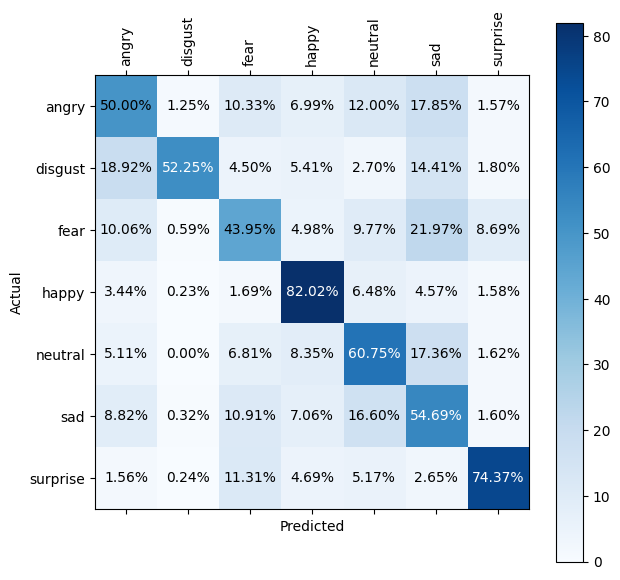

NB_2_vgg16_bn_epochs_3_lr_0.0025


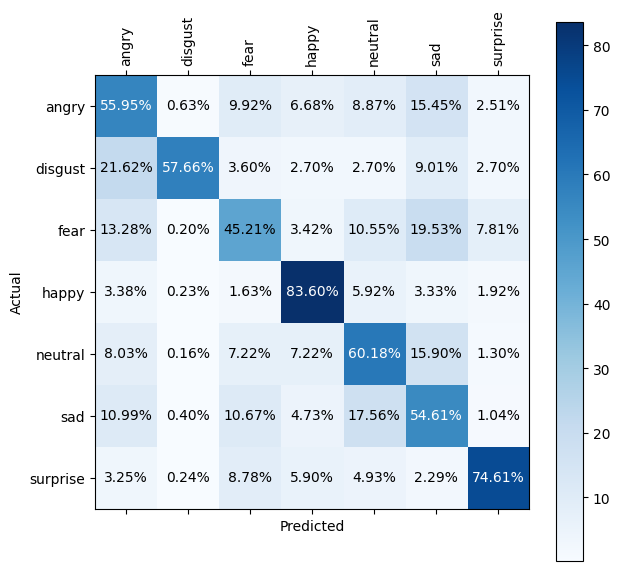

In [11]:
import matplotlib.pyplot as plt
import numpy as np

for learner in learners:
    # Print the learner name
    print(learner['name'])

    # Get the confusion matrix data
    interp = ClassificationInterpretation.from_learner(learner['learner'])
    losses,idxs = interp.top_losses()

    # Get the confusion matrix data
    cm = interp.confusion_matrix()

    # Calculate the percentage values for the confusion matrix
    cm_percentage = (cm / cm.sum(axis=1)[:, np.newaxis]) * 100

    # Get the class names from interp object
    classes = interp.vocab

    # Call the custom plot function
    plot_confusion_matrix_percent(cm_percentage, classes, figsize=(7, 7), dpi=100)


### Prediction of Own Images

In [ ]:
# load png image to make predictions

# Convert NumPy array to PIL Image and use fastai's PILImage to ensure it's in the right format
img = PILImage.create("../data/test_predict/surprise.png")

# Resize and convert the image to grayscale
img = img.resize((48, 48))
img = img.convert("L")

# Convert back to fastai's PILImage
img = PILImage(img)

# Make predictions
predicted, tensor_indx, probs = learners[3].predict(img)

display(predicted)
display(tensor_indx)
display(probs)

predicted_emotion = str(predicted)
emotion_probability = probs[tensor_indx].item()

display(predicted_emotion) 
display(emotion_probability)